In [2]:
## Importing Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from keras import Input
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 1. Loading the data

In [174]:
df = pd.read_csv('./all_stocks_5yr.csv')

In [7]:
df.head(10)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL


In [8]:
df.shape

(619040, 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


## 2. Exploratory Data Analysis

In [11]:
### Checking for null values

df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [14]:
df[df.isna().any(axis=1)]

,date,open,high,low,close,volume,Name
82949,2017-07-26,NaN,NaN,NaN,69.0842,3,BHF
165734,2015-07-17,NaN,88.76,88.24,88.7200,2056819,DHR
165857,2016-01-12,NaN,NaN,NaN,88.5500,0,DHR
205076,2015-07-17,NaN,48.49,47.85,47.9200,1246786,ES
239832,2016-07-01,NaN,NaN,NaN,49.5400,0,FTV
434379,2015-07-17,NaN,47.31,46.83,46.9900,1229513,O
434502,2016-01-12,NaN,NaN,NaN,52.4300,0,O
478594,2015-06-09,NaN,NaN,NaN,526.0900,12135,REGN
558213,2016-04-07,NaN,NaN,NaN,41.5600,0,UA
581906,2015-05-12,NaN,NaN,NaN,124.0800,569747,VRTX


### Removing null values
Since only a small amount of data contains null value we will remove these rows

In [175]:
df.dropna(ignore_index=True, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619029 entries, 0 to 619028
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619029 non-null  object 
 1   open    619029 non-null  float64
 2   high    619029 non-null  float64
 3   low     619029 non-null  float64
 4   close   619029 non-null  float64
 5   volume  619029 non-null  int64  
 6   Name    619029 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [17]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [20]:
df['Name'].nunique()

505

In [21]:
df['Name'].value_counts().max()

1259

In [22]:
df['Name'].value_counts().min()

44

In [30]:
sf = df['Name'].value_counts()
sf[sf == 1259]

Name
AAL     1259
NOV     1259
NLSN    1259
NKE     1259
NI      1259
        ... 
EQT     1259
DIS     1259
DLR     1259
DLTR    1259
DTE     1259
Name: count, Length: 468, dtype: int64

In [54]:
filter_df = df.groupby(['Name']).sum('volume').sort_values(by = 'volume',ascending=False)
filter_df.head(10)

,open,high,low,close,volume
Name,,,,,
BAC,22292.6398,22493.8851,22081.8351,22289.5600,117884953591
AAPL,137300.7850,138428.4580,136150.2604,137314.9734,68046305767
GE,33400.2499,33632.1975,33156.5777,33396.6640,53023644686
F,17767.8498,17914.2024,17593.3269,17755.2200,43388129992
FB,121436.9197,122609.9049,120187.9662,121466.5704,43258314899
MSFT,64242.2304,64757.9329,63743.6695,64288.4185,42641653597
AMD,7055.8329,7198.0141,6907.6707,7052.7450,40941468586
MU,28939.2230,29378.2445,28460.0824,28922.4941,38082749687
INTC,40041.9061,40395.6653,39707.5002,40075.8972,36922332801


**Top 10 Companies with highest volumes**

BAC - Bank of America\
AAPL - Apple\
GE - General Electric\
F - Ford\
FB - Facebook\
MSFT - Microsoft\
AMD - Advanced Micro Devices\
INTC - Intel Corp\
CSCO - Cisco 

In [55]:
filter_df.tail(10)

,open,high,low,close,volume
Name,,,,,
SNA,175326.945,176675.7131,173925.7070,175366.1000,530283843
ESS,261471.045,263681.1862,259187.0043,261511.3400,477004832
RE,230230.725,231959.8122,228492.2963,230274.7800,434037215
DXC,18465.805,18629.4135,18319.5162,18475.4700,424529395
HII,168337.265,169919.3432,166769.2972,168454.4500,418791148
WLTW,70686.220,71243.6739,70070.8975,70719.3700,414734590
AZO,780165.305,786794.8499,773371.4067,780206.9000,397585127
MTD,448330.940,452312.3815,444527.0450,448578.5500,214489754
BHF,8531.905,8633.1542,8428.1341,8530.8868,144878389


**Top 10 Companies with lowest volumes**

APTV - Aptiv PLC \
BHF - Brighthouse Financial \
MTD - Mettler-Toledo International \
AZO - Autozone\
WLTW - Willis Towers Watson Public Limited Company\
HII - Huntington Ingalls Industries\
DXC - DXC Technology\
RE  - RE Royalties\
ESS - Essex Property Trust \
SNA - Snap-On

### Selecting Data

In [91]:
company = list(filter_df.head(10).index)
company

['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']

In [182]:
data = df[df["Name"].isin(company)].reset_index(drop=True)

In [183]:
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


### Converting Date

For further analysis of data we need date to be in the appropriate format. Using the pandas function we can convert the object type date to datetime format

In [203]:
data.to_csv("10 company.csv")

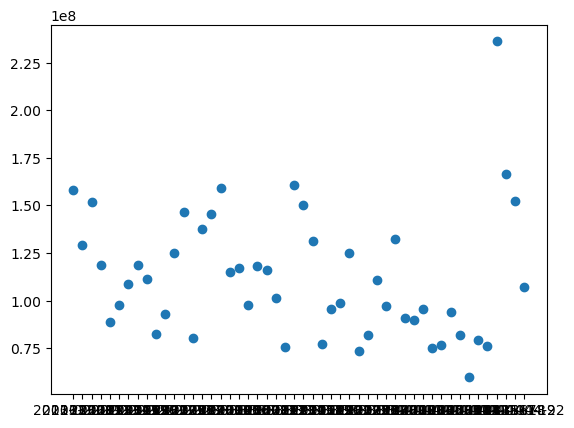

In [62]:
plt.scatter(x=data['date'][:50],y=data['volume'][:50])

In [190]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12590 entries, 0 to 12589
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               12590 non-null  datetime64[ns]
 1   open               12590 non-null  float64       
 2   high               12590 non-null  float64       
 3   low                12590 non-null  float64       
 4   close              12590 non-null  float64       
 5   volume             12590 non-null  int64         
 6   Name               12590 non-null  object        
 7   price_chang        12589 non-null  float64       
 8   price_change_pct   12589 non-null  float64       
 9   volume_change      12589 non-null  float64       
 10  volume_change_pct  12589 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 1.1+ MB


In [184]:
data_cp = data.copy()

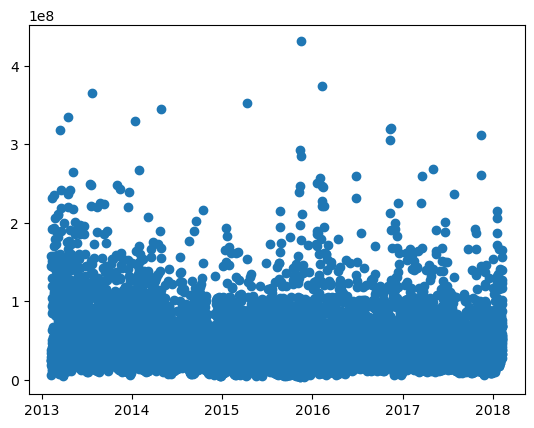

In [65]:
plt.scatter(x=data['date'],y=data['volume'])

In [69]:
data.describe()

,date,open,high,low,close,volume
count,12590,12590.000000,12590.000000,12590.000000,12590.000000,1.259000e+04
mean,2015-08-09 05:44:16.393963520,40.300525,40.666639,39.923701,40.309134,4.132370e+07
min,2013-02-08 00:00:00,1.620000,1.690000,1.610000,1.620000,2.606577e+06
25%,2014-05-09 00:00:00,15.900000,16.040000,15.732500,15.870000,2.211401e+07
50%,2015-08-10 00:00:00,27.220000,27.450000,26.985000,27.232500,3.105966e+07
75%,2016-11-07 00:00:00,45.545000,46.085000,45.092500,45.595000,4.849717e+07
max,2018-02-07 00:00:00,192.040000,195.320000,189.980000,193.090000,4.313326e+08
std,NaN,37.920988,38.211248,37.615958,37.932401,3.253543e+07


### Stock price and Volume Analysis

**Closing Price**\
The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

**Volume of Sales**\
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.


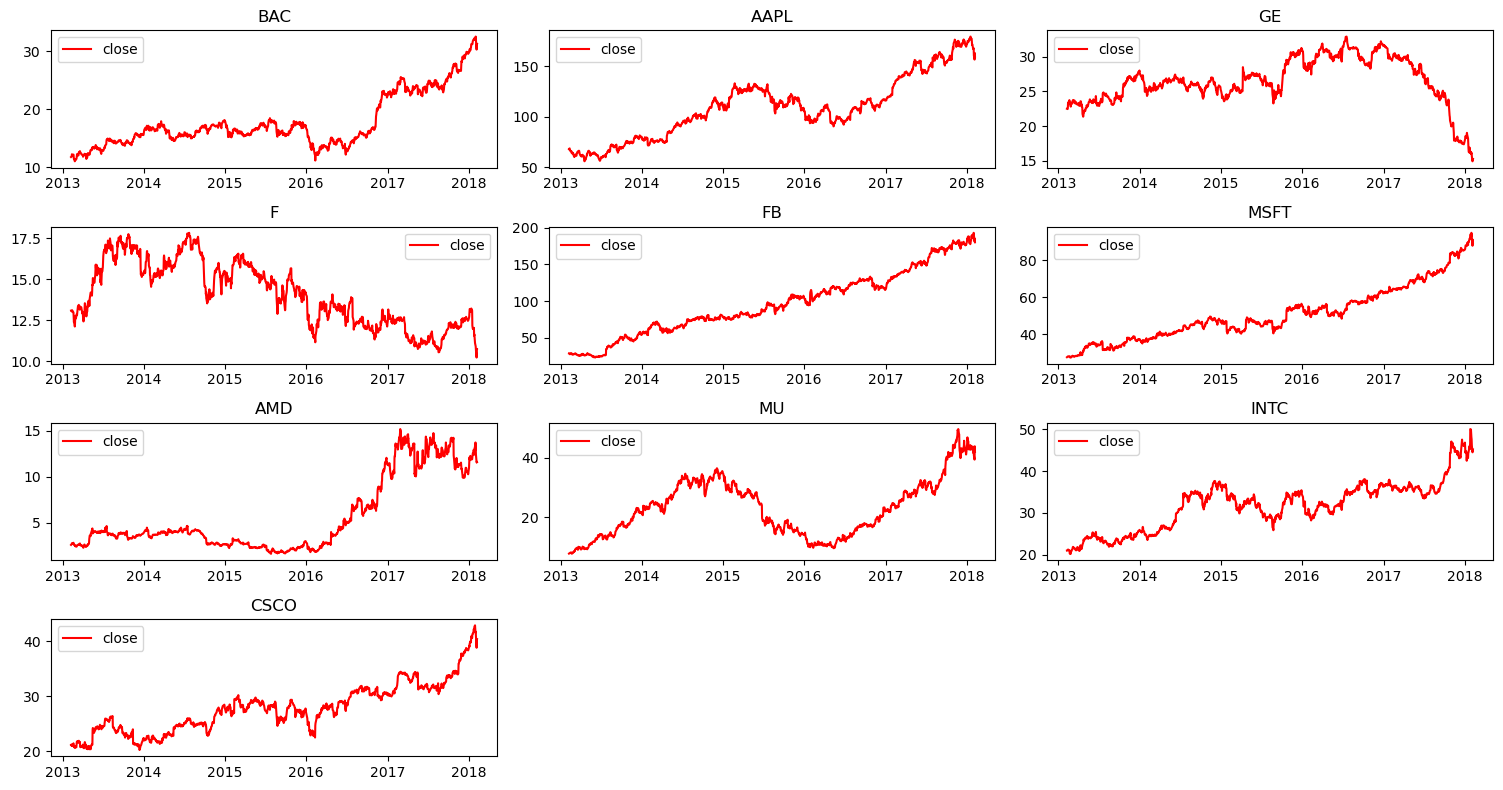

In [120]:
### Plotting closing price of each company over the years
plt.figure(figsize=(15, 8)) 
for index, comp in enumerate(company, 1): 
    plt.subplot(4, 3, index) 
    c = data[data['Name'] == comp] 
    plt.plot(c['date'], c['close'], c="r", label="close") 
    plt.title(comp) 
    plt.legend() 
    plt.tight_layout()

For the above plot, we can see that mostly the stock prices have gone up in the span of 5 years. There are only 2 companies whose stock went down that is `General Electric` and `Ford`. \
Additionally, Facebook has witnessed highest growth and apple the second highest. On the other hand AMD witnessed the lowest growth. 

Let's take a quick look at the numbers of Apple, facebook, and AMD 

In [123]:
data[data['Name'] == 'AAPL'].describe()

,date,open,high,low,close,volume
count,1259,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,2015-08-09 05:44:16.393963264,109.055429,109.951118,108.141589,109.066698,5.404790e+07
min,2013-02-08 00:00:00,55.424200,57.085700,55.014200,55.789900,1.147592e+07
25%,2014-05-10 12:00:00,84.647800,85.334950,84.250650,84.830650,2.969438e+07
50%,2015-08-10 00:00:00,108.970000,110.030000,108.050000,109.010000,4.566893e+07
75%,2016-11-05 12:00:00,127.335000,128.100000,126.290000,127.120000,6.870872e+07
max,2018-02-07 00:00:00,179.370000,180.100000,178.250000,179.260000,2.668336e+08
std,NaN,30.549220,30.686186,30.376224,30.556812,3.346835e+07


In [124]:
data[data['Name'] == 'FB'].describe()

,date,open,high,low,close,volume
count,1259,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,2015-08-09 05:44:16.393963264,96.455059,97.386739,95.463039,96.478610,3.435927e+07
min,2013-02-08 00:00:00,22.990000,23.090000,22.670000,22.899000,5.913066e+06
25%,2014-05-10 12:00:00,64.720000,65.617800,63.880000,64.861750,1.780491e+07
50%,2015-08-10 00:00:00,90.590000,92.060000,89.650000,90.950000,2.608916e+07
75%,2016-11-05 12:00:00,125.785000,126.680000,124.950000,126.145000,4.252176e+07
max,2018-02-07 00:00:00,192.040000,195.320000,189.980000,193.090000,3.653806e+08
std,NaN,43.765800,43.972039,43.542059,43.799446,2.672781e+07


In [126]:
data[data['Name'] == 'AMD'].describe()

,date,open,high,low,close,volume
count,1259,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,2015-08-09 05:44:16.393963264,5.604315,5.717247,5.486633,5.601863,3.251904e+07
min,2013-02-08 00:00:00,1.620000,1.690000,1.610000,1.620000,2.606577e+06
25%,2014-05-10 12:00:00,2.670000,2.720000,2.630000,2.670000,1.240657e+07
50%,2015-08-10 00:00:00,3.850000,3.930000,3.790000,3.850000,2.222858e+07
75%,2016-11-05 12:00:00,7.490000,7.640000,7.270000,7.495000,4.174201e+07
max,2018-02-07 00:00:00,15.450000,15.650000,14.520000,15.200000,2.683365e+08
std,NaN,3.979483,4.054507,3.889996,3.971779,3.079792e+07


### Monthly charts

Since we are dealing with 5 years of stock data, it is ideal to take a look at montly charts. Doing so will help us in the following ways:

1. Smoother trends and more general insights, reducing noise from daily fluctuations.
2. Useful for long-term investment decisions or performance reviews.
3. Suitable for strategic planning and less frequent trading

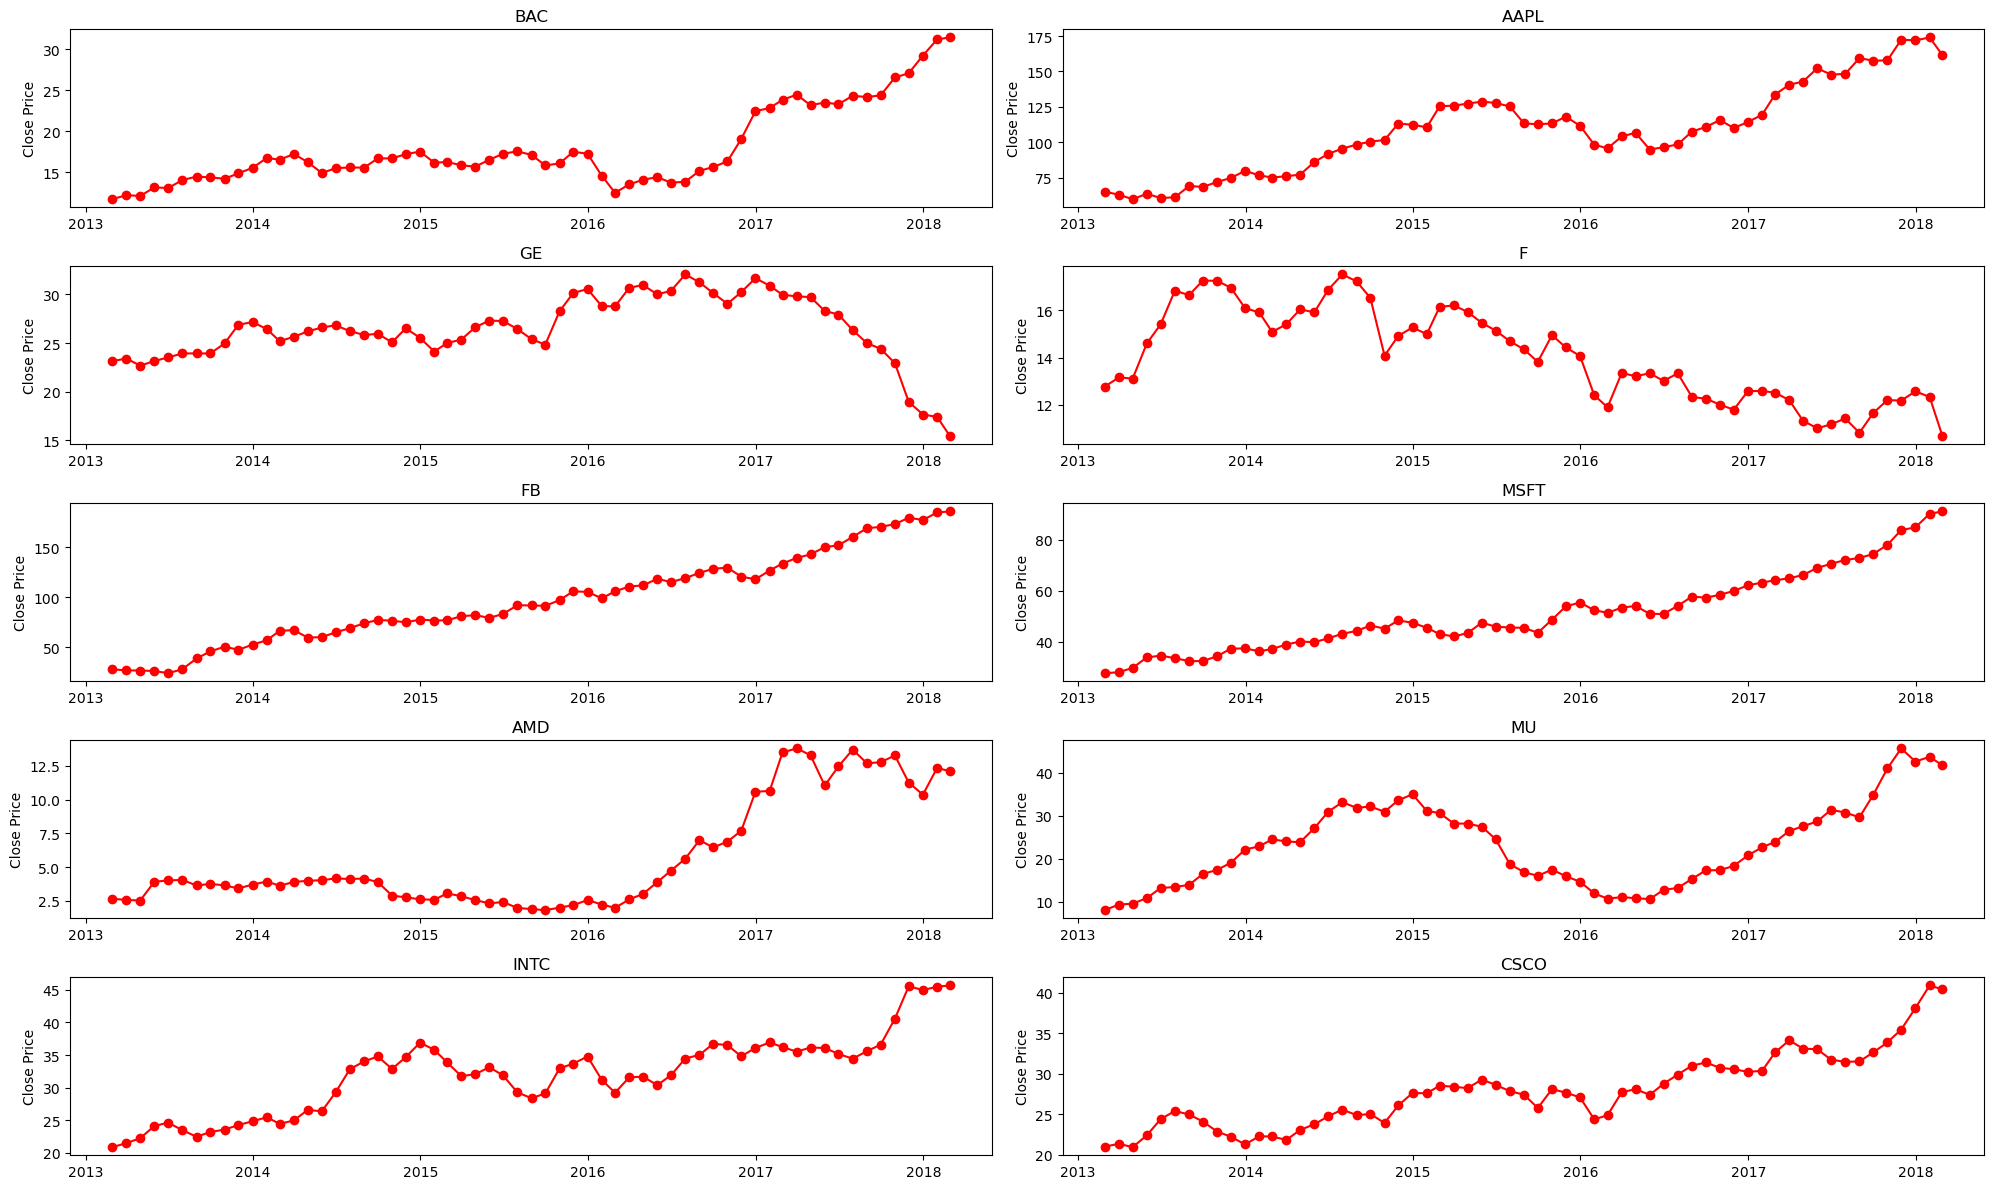

In [251]:
# Plotting the closing price for each month
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 12))  # Adjust for 10 plots
axes = axes.flatten()

for i, comp in enumerate(company):
    ax1 = axes[i]
    d = data[data['Name'] == comp]  # Filter data by company
    d = d.set_index('date') if 'date' in d.columns else d
    monthly_data = d['close'].resample('ME').mean() # Resample the data to get weekly averages
    ax1.plot(monthly_data.index, monthly_data.values, color='red', label='Close Price', marker='o', linestyle='-')
    ax1.set_title(comp)
    ax1.set_ylabel('Close Price')

    
fig.tight_layout()
plt.show()

We can notice certain trends more clearly with the monthly plot.

1. Some companies like Facebook and Microsoft have consistent (linear growth over the years)
2. Companies like AMD, BAC and MU have experienced sharp growth after 2016.
3. Ford and Intel Corp shows high volatility over the period.

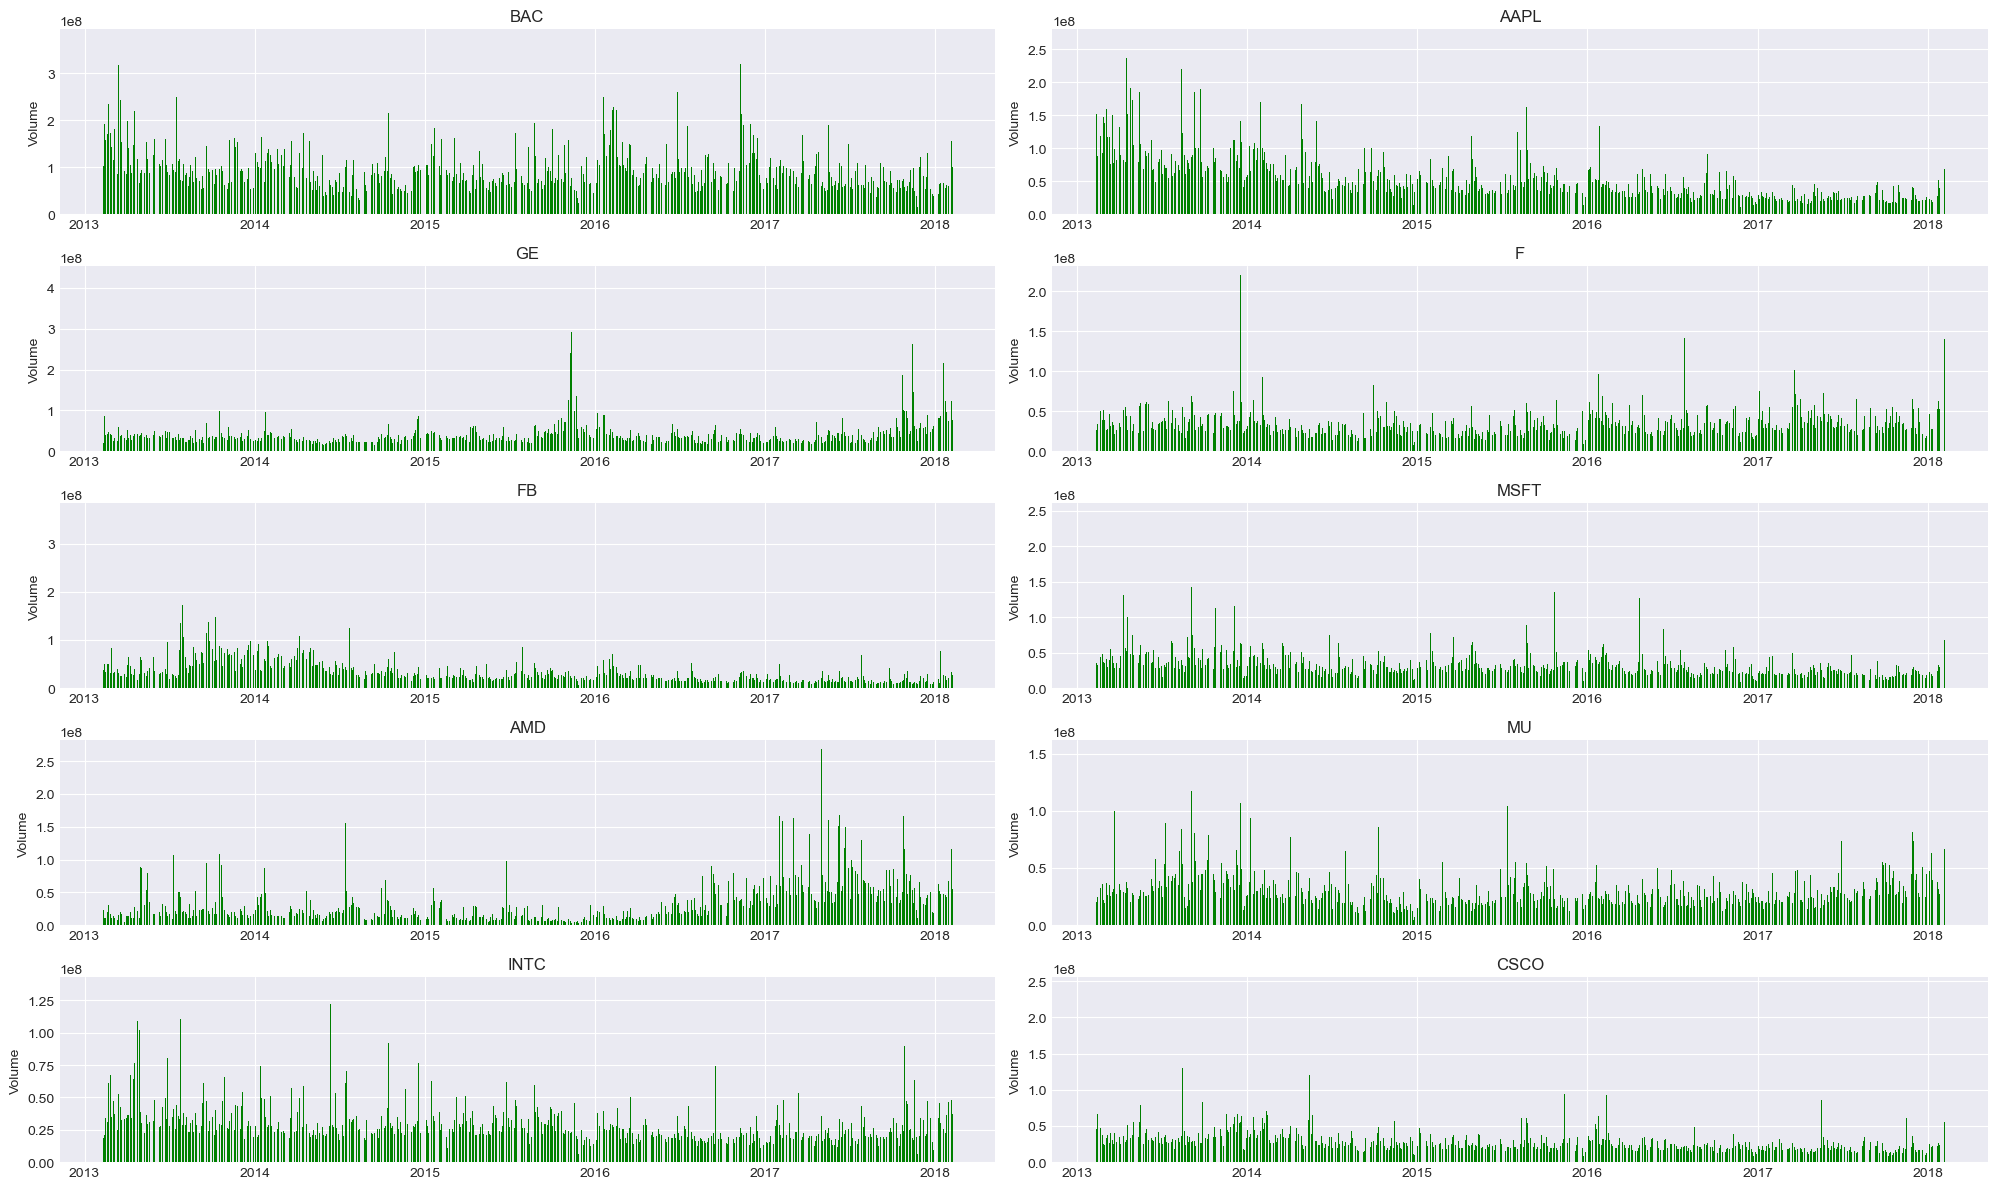

In [266]:
### Plotting sales volume of each company.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 12))  # Adjust for 10 plots
axes = axes.flatten()

for i, comp in enumerate(company):
    ax1 = axes[i]
    d = data[data['Name'] == comp]  # Filter data by company
    
    ax1.bar(d['date'],d['volume'], color='green', label='Volume')
    ax1.set_title(comp)
    ax1.set_ylabel('Volume')

    
fig.tight_layout()
plt.show()

Following observation can be made from the above plot.

1. FB, MSFT, AAPL, and GE: Noticeable peaks in 2013 and 2016-2017, reflecting external market changes or company-specific events.
2. MU, AMD, and INTC: Show higher trading volume on average, especially in later years, suggesting growing investor interest or volatility.
3. BAC, AMD, and MU appear to have more frequent spikes compared to others, signaling frequent trading activity.
4. FB and GE have fewer but sharper peaks, indicating specific periods of concentrated interest.

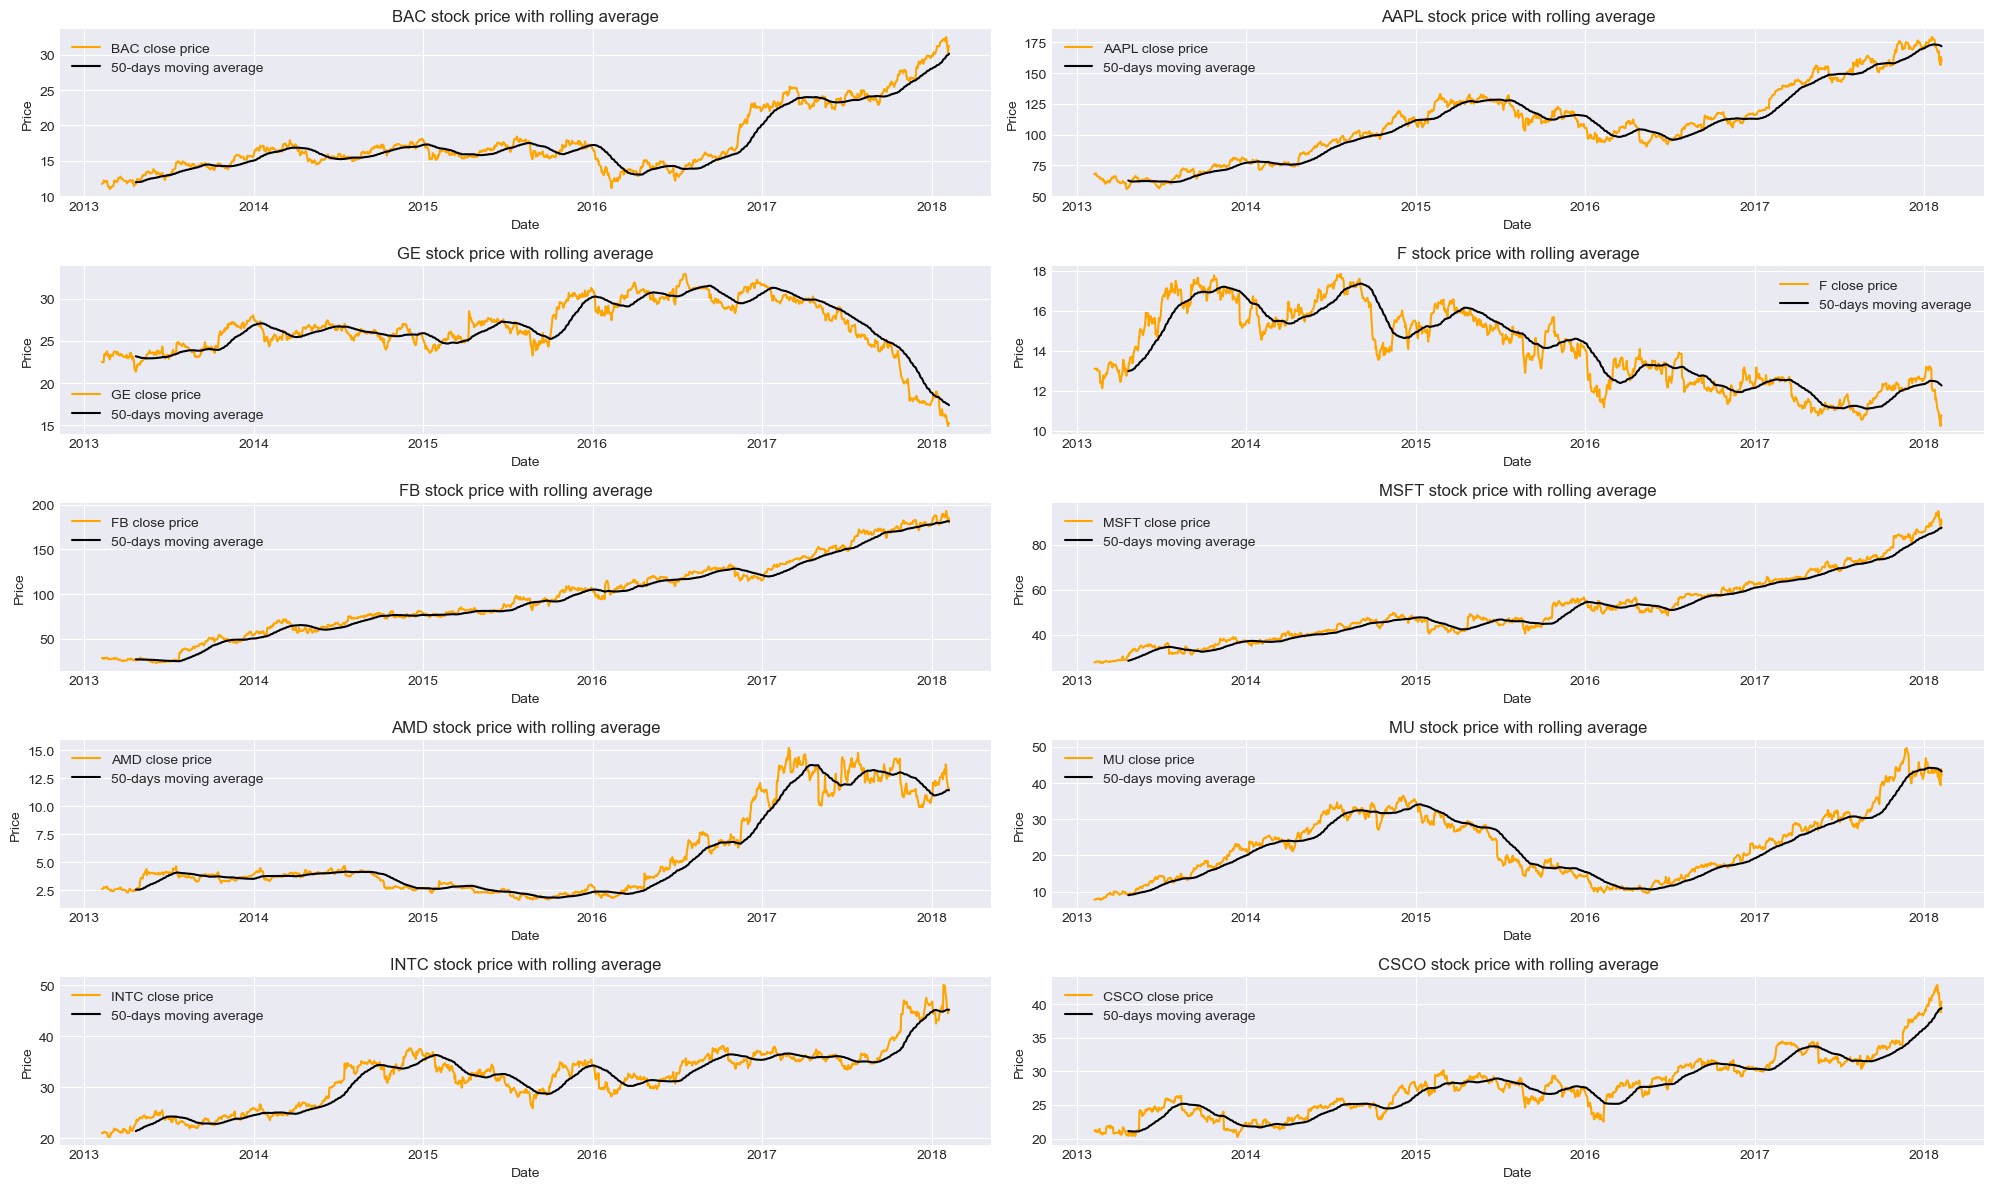

In [274]:
### Plotting sales volume of each company.
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 12))  # Adjust for 10 plots
axes = axes.flatten()

for i, comp in enumerate(company):
    ax1 = axes[i]
    d = data[data['Name'] == comp]  # Filter data by company
    ma_50 = d['close'].rolling(window=50).mean()
    ax1.plot(d['date'], d['close'], color='orange', label= f"{comp} close price")
    ax1.plot(d['date'],ma_50, color='black', label='50-days moving average')
    ax1.set_title(f"{comp} stock price with rolling average")
    ax1.set_ylabel('Price')
    ax1.set_xlabel('Date')
    ax1.legend()

fig.tight_layout()
plt.show()

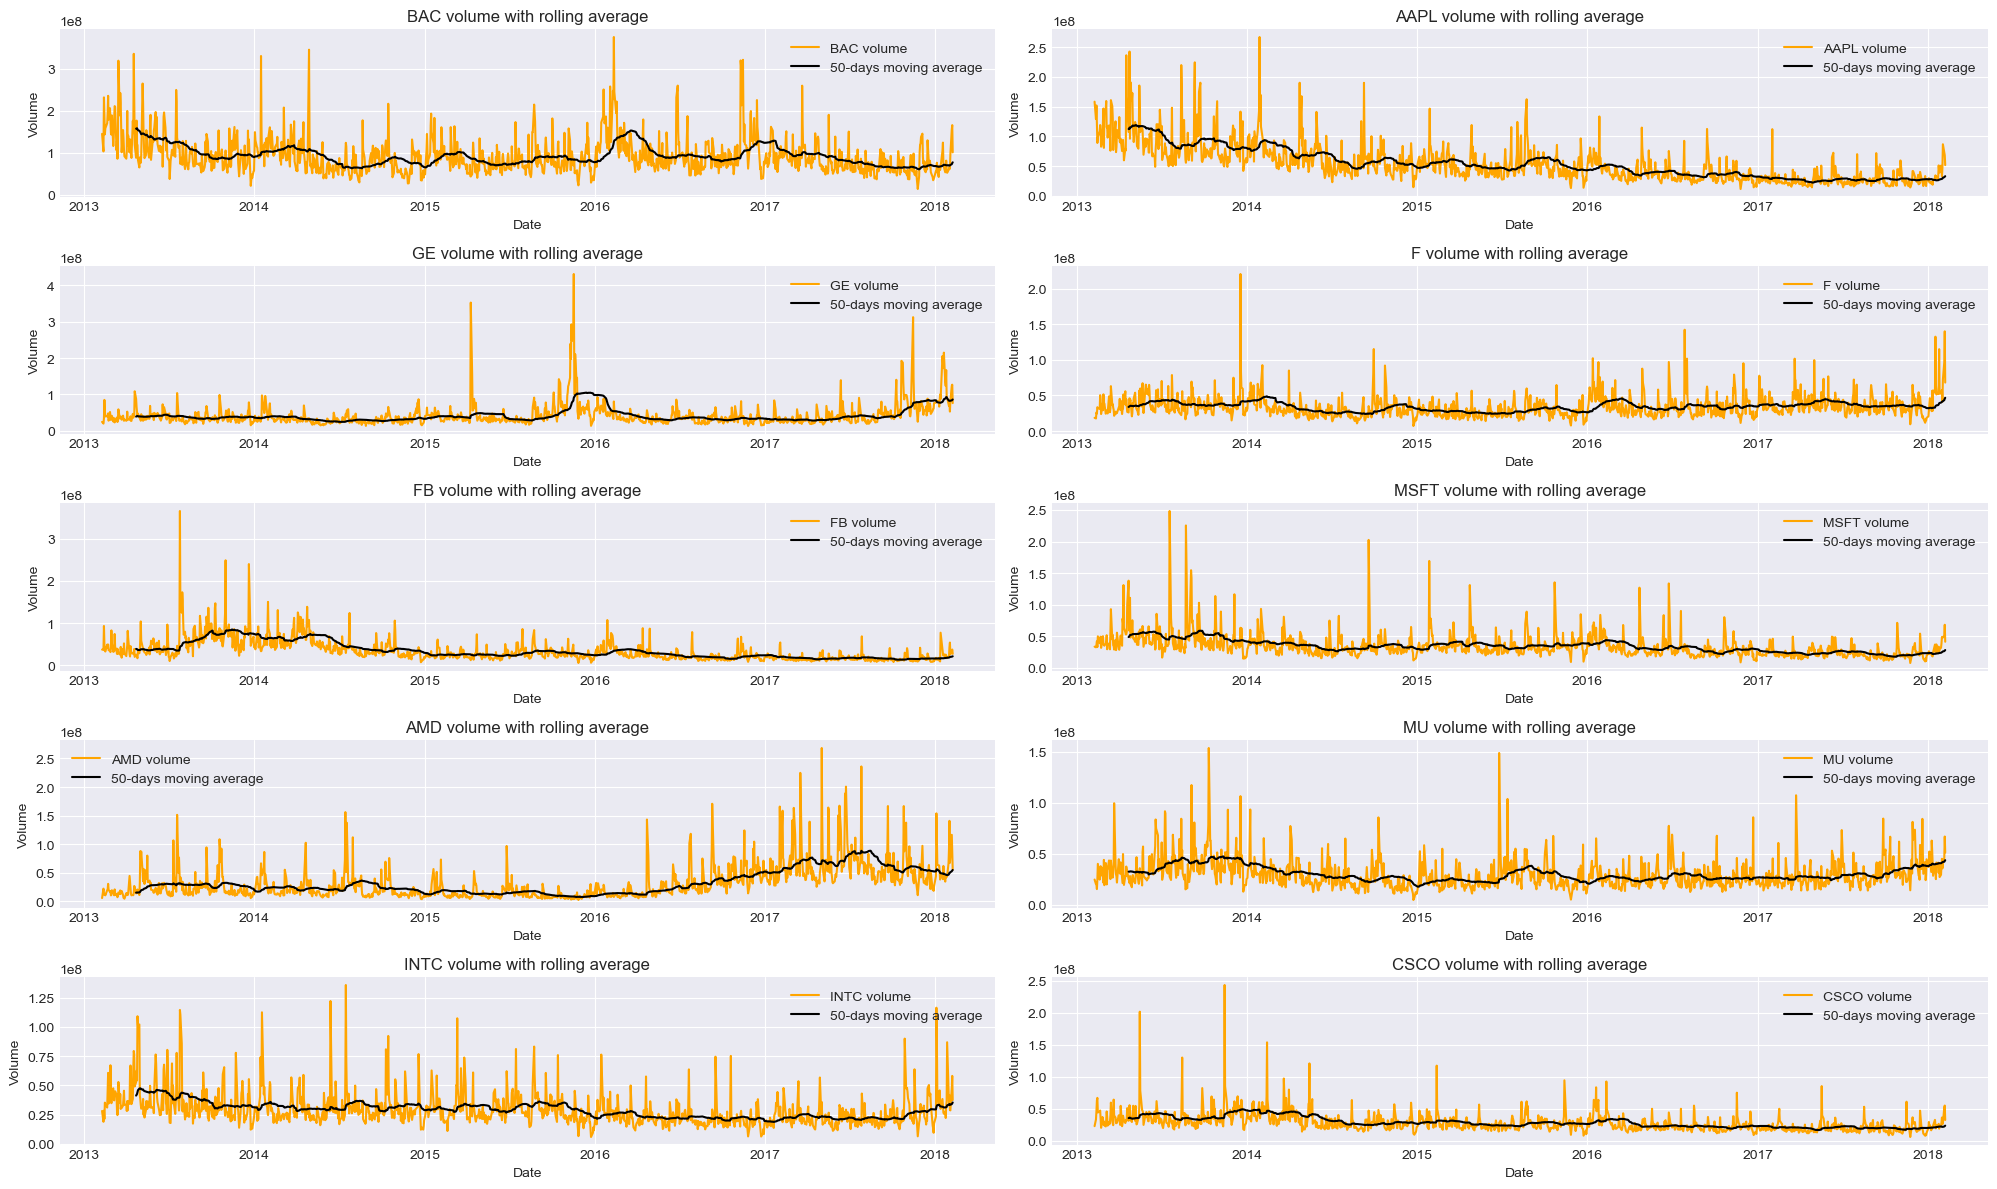

In [273]:
### Plotting sales volume of each company.
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 12))  # Adjust for 10 plots
axes = axes.flatten()

for i, comp in enumerate(company):
    ax1 = axes[i]
    d = data[data['Name'] == comp]  # Filter data by company
    ma_50 = d['volume'].rolling(window=50).mean()
    ax1.plot(d['date'], d['volume'], color='orange', label= f"{comp} volume")
    ax1.plot(d['date'],ma_50, color='black', label='50-days moving average')
    ax1.set_title(f"{comp} volume with rolling average")
    ax1.set_ylabel('Volume')
    ax1.set_xlabel('Date')
    ax1.legend()

fig.tight_layout()
plt.show()

**Next Steps**

Overlay these plots with stock price data to understand how volume spikes impact prices.

### Correlation between Stock price and Volume

High trading volumes often convey valuable information about investors' sentiments regarding a market or security. For instance, a substantial price increase coupled with a significant uptick in volume might signal a sustained bullish trend or a bullish reversal. In contrast, a significant price decrease accompanied by increased volume can indicate a continuing bearish trend or a potential bearish reversal

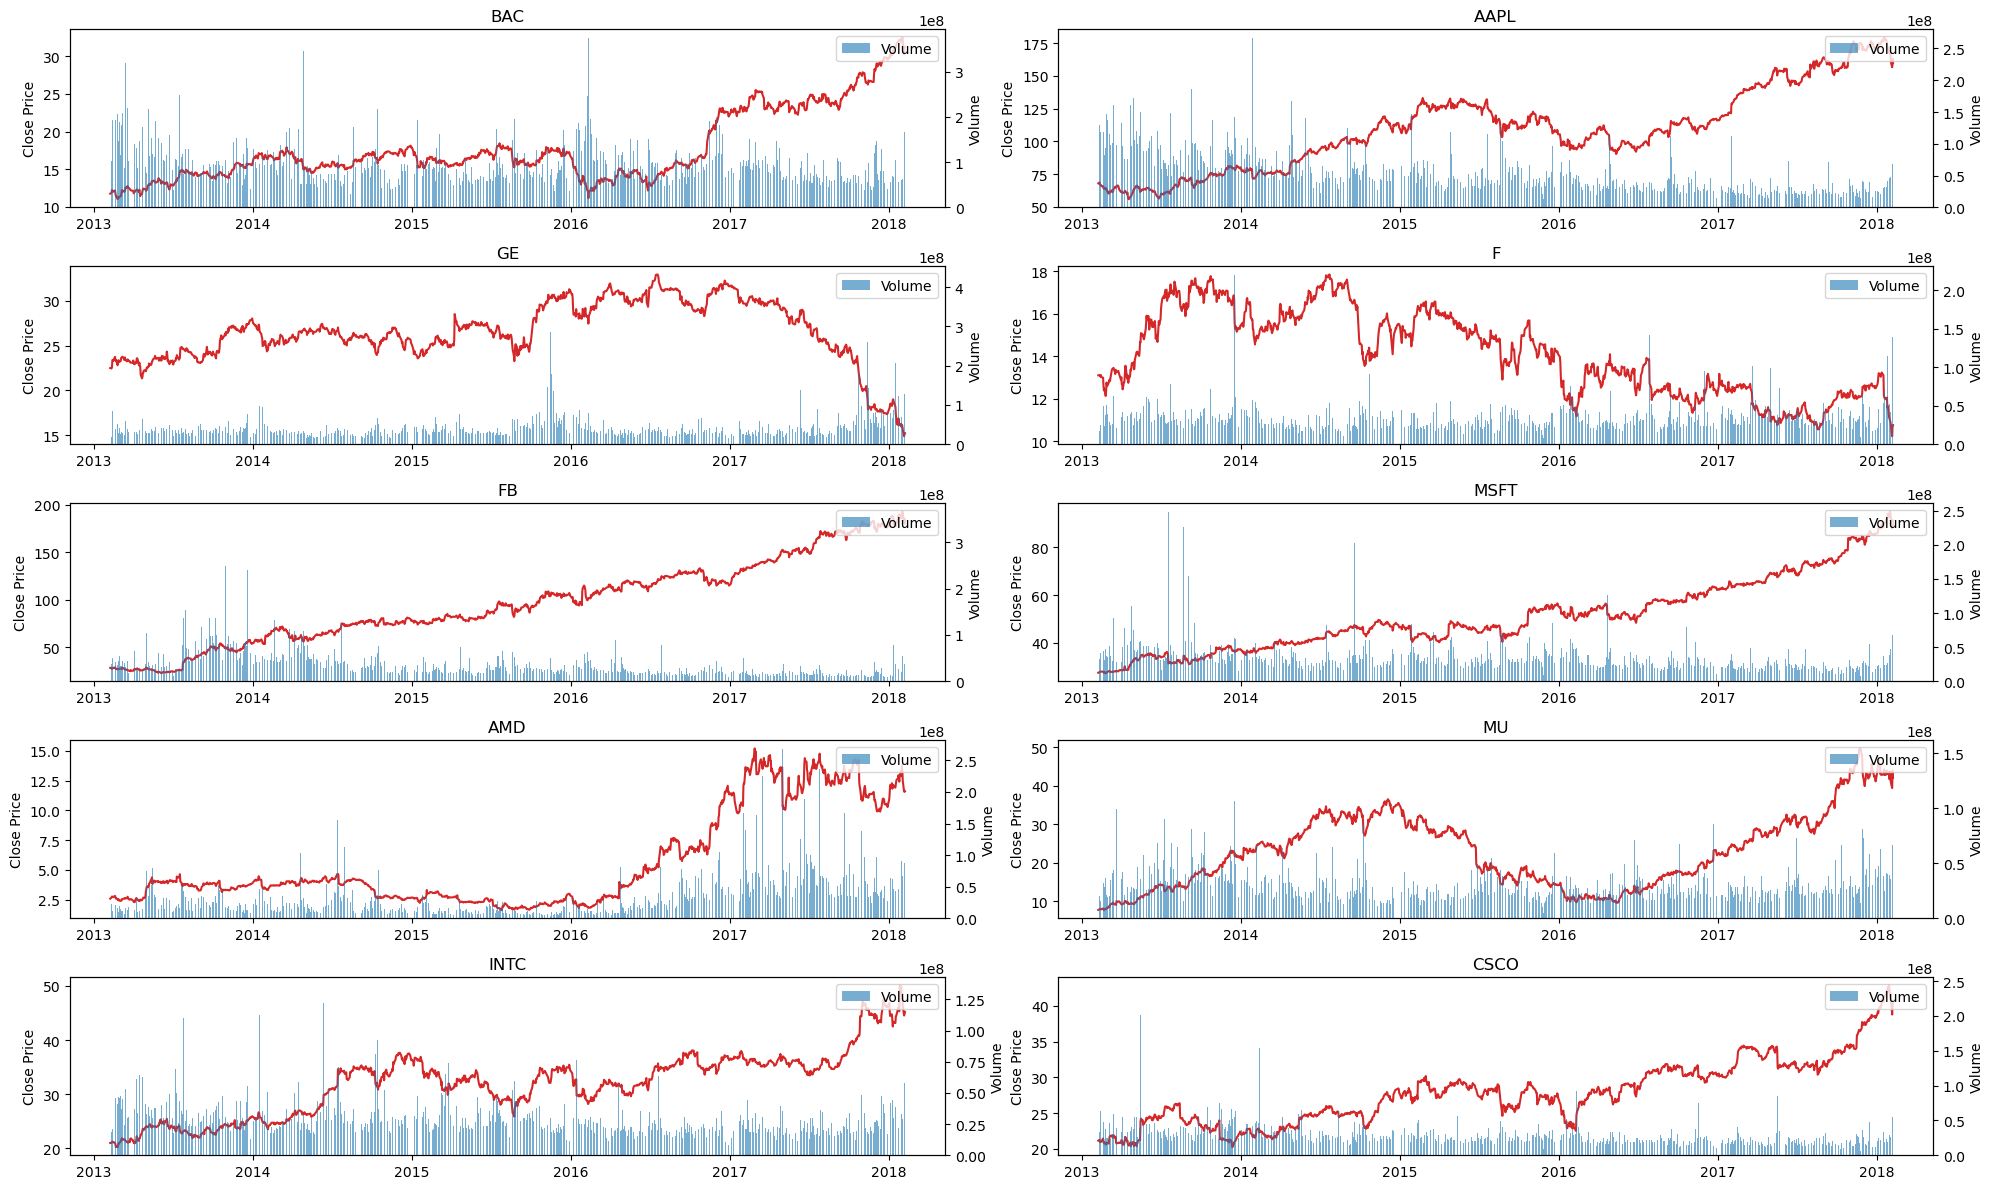

In [253]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 12))  # Adjust for 10 plots
axes = axes.flatten()

for i, comp in enumerate(company):
    ax1 = axes[i]
    d = data[data['Name'] == comp]  # Filter data by company
    
    ax1.plot(d['date'], d['close'], color='tab:red', label='Close Price')
    ax1.set_title(comp)
    ax1.set_ylabel('Close Price')
    
    ax2 = ax1.twinx()
    ax2.bar(d['date'], d['volume'], color='tab:blue', alpha=0.6, label='Volume')
    ax2.set_ylabel('Volume')
    plt.legend()

fig.tight_layout()
plt.show()

From the above charts we can notice that spike in volume is mostly accompanied by sparp decrease in price. 

To further enhance our analysis of the correlation between stock price and volume we need to calculate the absolute change and percent change of price and volume.

In [281]:
frames = []
for comp in company:
    d = data[data['Name'] == comp]
    d['price_change'] = d['close'].diff()
    d['price_change_pct'] = d['close'].pct_change()
    d['volume_change'] = d['volume'].diff()
    d['volume_change_pct'] = d['volume'].pct_change()
    frames.append(d)

data = pd.concat(frames)

/var/folders/d4/tmx_spfj2yn97sw31xpylfq80000gn/T/ipykernel_41194/359614984.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['price_change'] = d['close'].diff()
/var/folders/d4/tmx_spfj2yn97sw31xpylfq80000gn/T/ipykernel_41194/359614984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['price_change_pct'] = d['close'].pct_change()
/var/folders/d4/tmx_spfj2yn97sw31xpylfq80000gn/T/ipykernel_41194/359614984.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [289]:
data.head()

,date,open,high,low,close,volume,Name,price_change_pct,volume_change,volume_change_pct,price_change
2518,2013-02-08,11.86,11.90,11.72,11.760,145217221,BAC,NaN,NaN,NaN,NaN
2519,2013-02-11,11.73,11.90,11.67,11.860,103499848,BAC,0.008503,-41717373.0,-0.287276,0.100
2520,2013-02-12,11.87,12.34,11.78,12.245,231771561,BAC,0.032462,128271713.0,1.239342,0.385
2521,2013-02-13,12.35,12.42,12.05,12.170,192478919,BAC,-0.006125,-39292642.0,-0.169532,-0.075
2522,2013-02-14,12.09,12.27,12.07,12.130,143901737,BAC,-0.003287,-48577182.0,-0.252377,-0.040


In [290]:
data.describe()

,date,open,high,low,close,volume,price_change_pct,volume_change,volume_change_pct,price_change
count,12590,12590.000000,12590.000000,12590.000000,12590.000000,1.259000e+04,12580.000000,1.258000e+04,12580.000000,12580.00000
mean,2015-08-09 05:44:16.393963520,40.300525,40.666639,39.923701,40.309134,4.132370e+07,0.000901,3.462988e+03,0.074357,0.03195
min,2013-02-08 00:00:00,1.620000,1.690000,1.610000,1.620000,2.606577e+06,-0.242291,-2.535572e+08,-0.808983,-9.02000
25%,2014-05-09 00:00:00,15.900000,16.040000,15.732500,15.870000,2.211401e+07,-0.007514,-6.835936e+06,-0.200639,-0.19000
50%,2015-08-10 00:00:00,27.220000,27.450000,26.985000,27.232500,3.105966e+07,0.000506,-5.548560e+05,-0.020800,0.01000
75%,2016-11-07 00:00:00,45.545000,46.085000,45.092500,45.595000,4.849717e+07,0.009263,6.308421e+06,0.226841,0.24000
max,2018-02-07 00:00:00,192.040000,195.320000,189.980000,193.090000,4.313326e+08,0.522901,2.925520e+08,9.264611,14.66000
std,NaN,37.920988,38.211248,37.615958,37.932401,3.253543e+07,0.019921,2.183873e+07,0.470027,0.81592


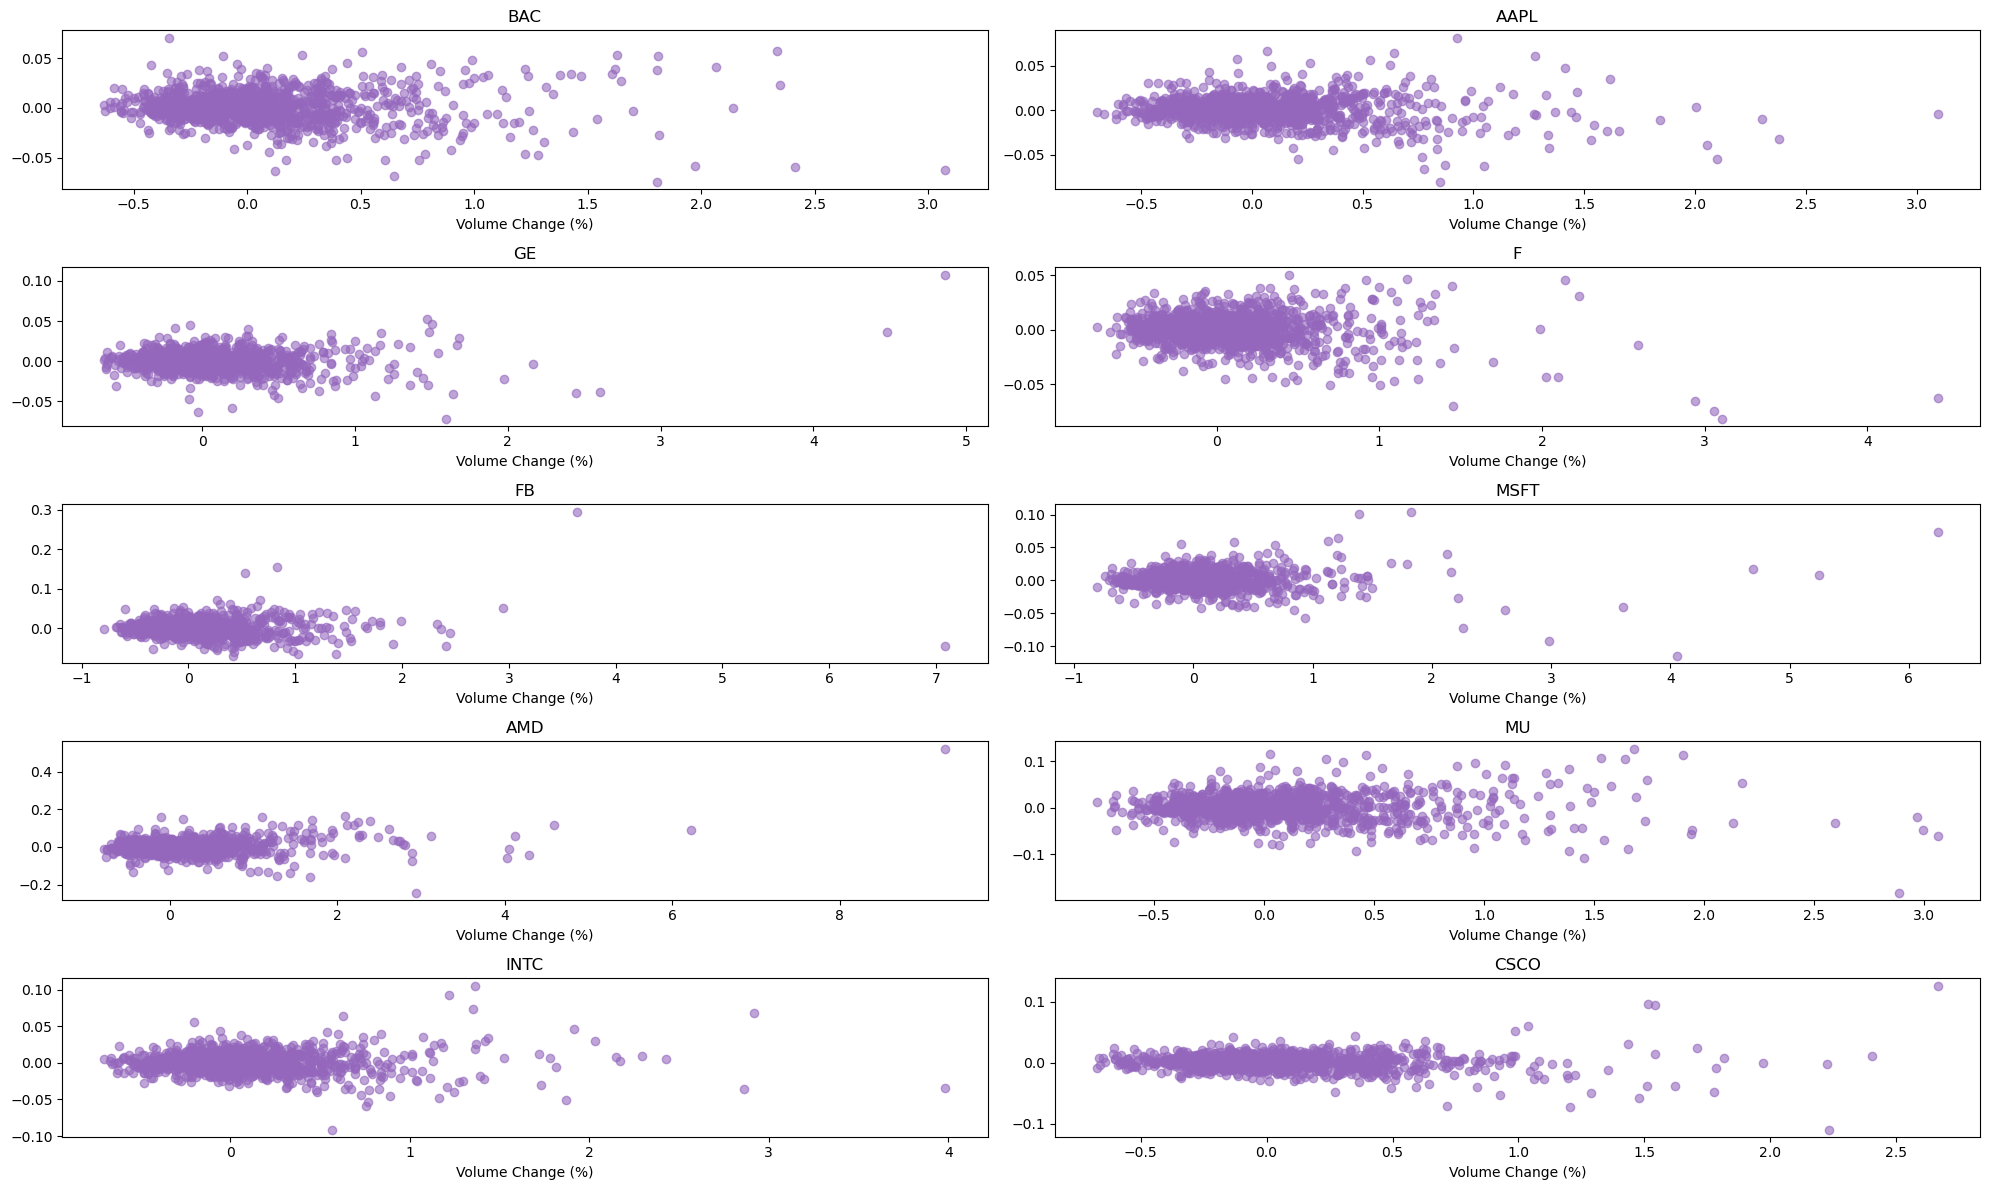

In [293]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 12))  # Adjust for 10 plots
axes = axes.flatten()

for i, comp in enumerate(company):
    ax1 = axes[i]
    d = data[data['Name'] == comp]  # Filter data by company
    
    ax1.scatter(d['volume_change_pct'], d['price_change_pct'], alpha=0.6, color='tab:purple', label='Close Price')
    ax1.set_title(comp)
    ax1.set_xlabel('Volume Change (%)')
    ax1.set_ylabel('Price Change (%)')

fig.tight_layout()
plt.show()

**Observations drawn from the above plot**

1. For most companies, the scatter plots appear widely dispersed around zero, suggesting weak correlation between volume change (%) and price change (%).

2. Some companies, like FB or BAC, show slight clustering with a discernible upward or downward trend, suggesting a mild correlation between volume changes and price movements.

3. There are points far away from the dense cluster which may represent unusual event.

**To get further clarity on the correlation and outliers we will perform the following analysis:**

Calculate the correlation coefficients

#### Calculating correlation coefficient

In [292]:
### Calculating the pearsons correlation coefficient for each company
for comp in company:
    d = data[data['Name'] == comp]
    correlation = d['price_change_pct'].corr(d['volume_change_pct'])
    print(f" {comp} : {correlation}")

 BAC : -0.055863974921550576
 AAPL : -0.11011909528633985
 GE : 0.026803475859129285
 F : -0.18757617209703242
 FB : 0.050005712401153424
 MSFT : -0.029256366533610387
 AMD : 0.2506834410891576
 MU : -0.05680864466444592
 INTC : -0.004567164297088424
 CSCO : -0.0547697261019043


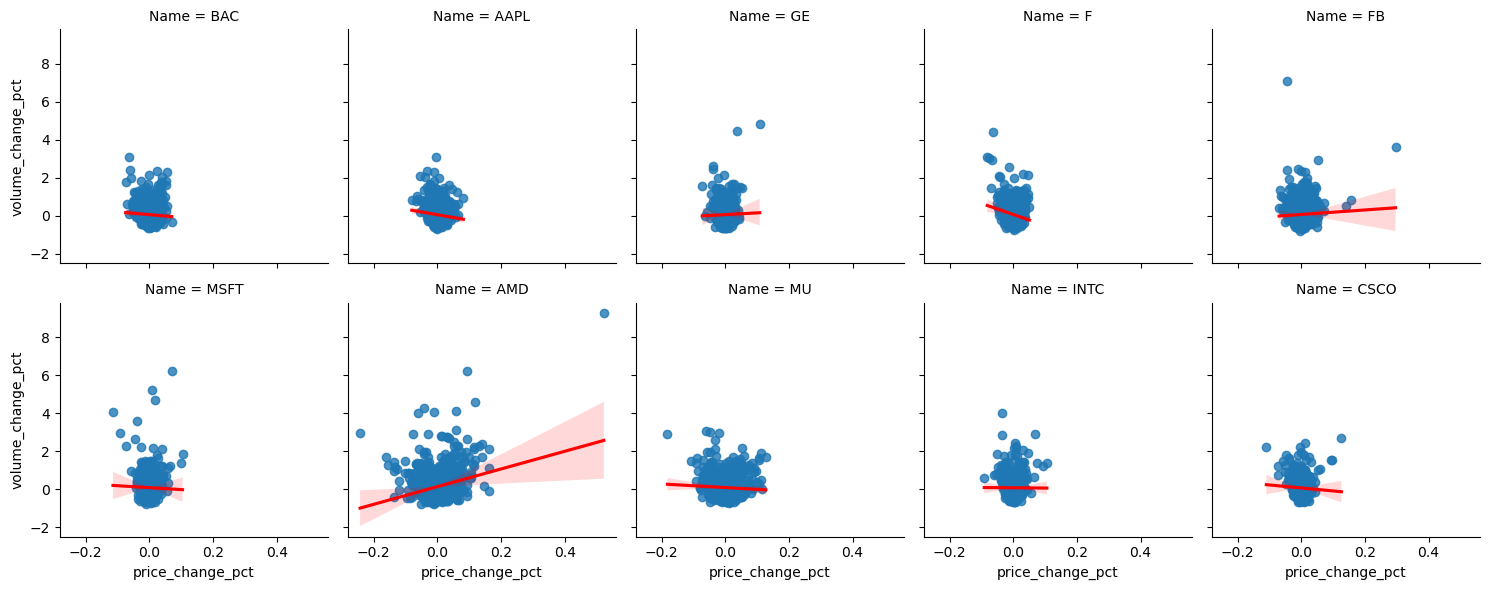

In [312]:
g = sns.FacetGrid(data, col="Name", col_wrap=5, height=3)
g.map(sns.regplot,'price_change_pct', 'volume_change_pct', line_kws={"color": "red"})

Based on the above analysis of stock price and volume these results can be drawn.

1. Positive Correlation:\
    AMD with a correlation of 0.226 suggests that, for this stock, there may be a slight tendency for price to rise as volume increases.

2. Negative Correlation:\
AAPL and GE have the weakest negative correlations (around -0.110 and -0.034 respectively), indicating minimal relationships between price and volume, but with small negative effects.

4. Near Zero Correlations:\
Most other stocks show very weak or negligible correlations (close to 0), suggesting that volume and price changes are largely independent for these stocks.

**Overall Conclusion:**\
There is no strong evidence that volume changes significantly impact stock price movements for most companies in this analysis.
AMD stands out as the only stock with a moderately positive correlation, which could indicate some market behavior where higher volume correlates with price increases, possibly due to investor sentiment or news events.

### Outlier Analysis

In [215]:
frames = []
for i, comp in enumerate(company):
    d = data[data['Name'] == comp]
    mean_volume = d['volume_change_pct'].mean()
    std_volume = d['volume_change_pct'].std()
    ev = d[(d['volume_change_pct'] > mean_volume + 3*std_volume) | 
                      (d['volume_change_pct'] < mean_volume - 3*std_volume)]
    frames.append(ev)

extreme_volume = pd.concat(frames)

In [216]:
extreme_volume

,date,open,high,low,close,volume,Name,price_chang,price_change_pct,volume_change,volume_change_pct
2518,2013-02-08,11.86,11.9000,11.720,11.76,145217221,BAC,0.16,0.013793,89458857.0,1.604402
2542,2013-03-15,12.52,12.6600,12.350,12.57,318880083,BAC,0.46,0.037985,205155493.0,1.803968
2577,2013-05-06,12.39,12.8900,12.360,12.88,264618705,BAC,0.64,0.052288,170442938.0,1.809839
2744,2014-01-02,15.69,16.1600,15.680,16.10,149225696,BAC,0.53,0.034040,91994732.0,1.607429
2753,2014-01-15,17.23,17.4200,17.110,17.15,330005943,BAC,0.38,0.022660,231488045.0,2.349705
...,...,...,...,...,...,...,...,...,...,...,...
4664,2016-08-17,30.97,30.9701,30.330,30.72,55071218,CSCO,-0.40,-0.012853,31671532.0,1.353502
4729,2016-11-17,29.91,30.0500,29.610,30.05,75252307,CSCO,-1.52,-0.048147,48155167.0,1.777131
4928,2017-09-05,32.15,32.2450,31.455,31.62,32650934,CSCO,-0.68,-0.021053,17964356.0,1.223182
4986,2017-11-27,36.51,37.0900,36.500,36.87,20942222,CSCO,0.38,0.010414,14786428.0,2.402034


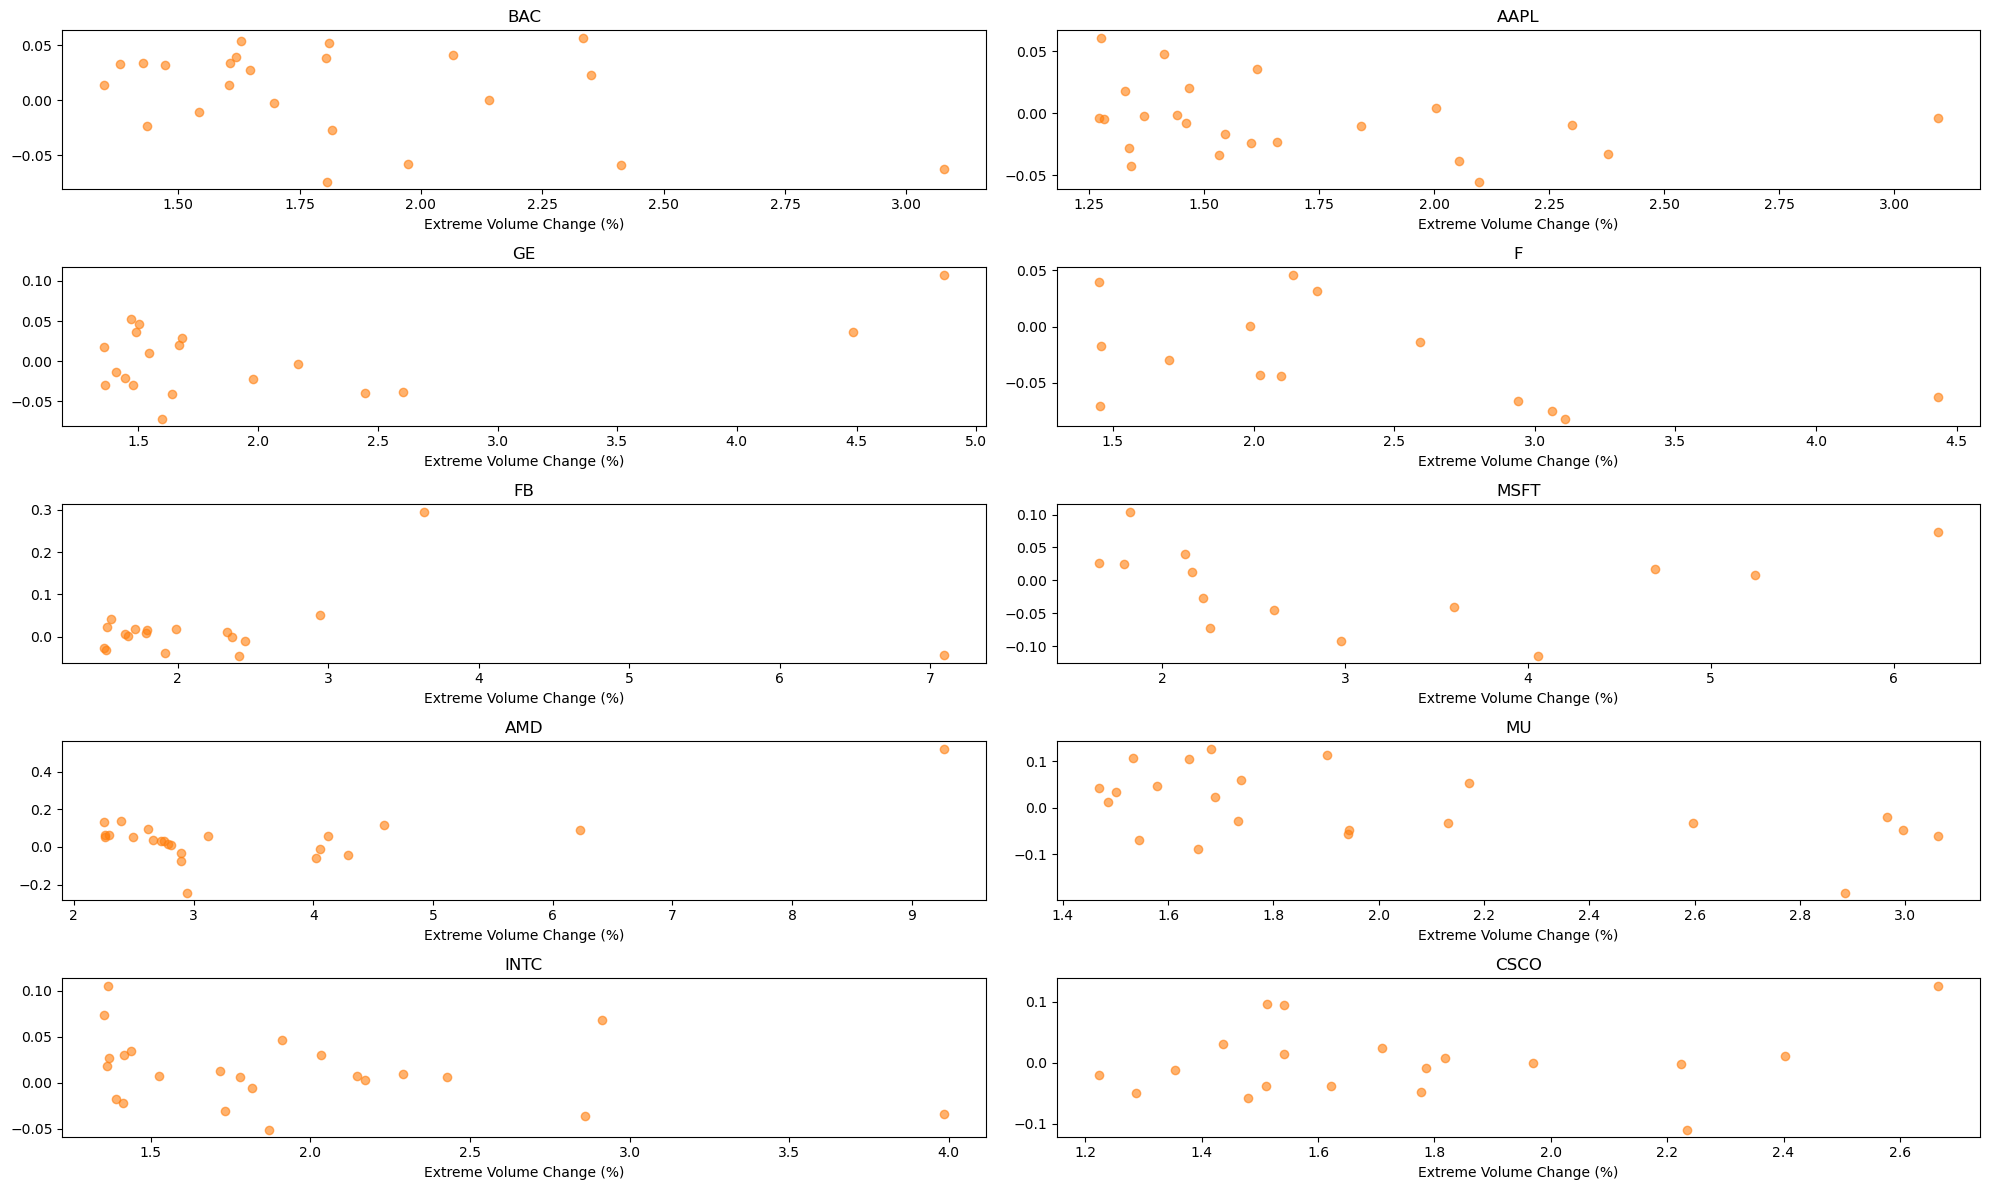

In [218]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 12))  # Adjust for 10 plots
axes = axes.flatten()

for i, comp in enumerate(company):
    ax1 = axes[i]
    d = extreme_volume[extreme_volume['Name'] == comp]  # Filter data by company
    
    ax1.scatter(d['volume_change_pct'], d['price_change_pct'], alpha=0.6, color='tab:orange', label='Close Price')
    ax1.set_title(comp)
    ax1.set_xlabel('Extreme Volume Change (%)')
    ax2.set_ylabel('Price Change (%)')

fig.tight_layout()
plt.show()

Let's substantiate the correlation by calculating pearsons coefficient.

In [220]:
### Calculating the pearsons correlation coefficient for each company
for comp in company:
    d = extreme_volume[extreme_volume['Name'] == comp]
    extreme_correlation = d['price_change_pct'].corr(d['volume_change_pct'])
    print(f"{comp}: {correlation}")

BAC: -0.010366982834805546
AAPL: -0.010366982834805546
GE: -0.010366982834805546
F: -0.010366982834805546
FB: -0.010366982834805546
MSFT: -0.010366982834805546
AMD: -0.010366982834805546
MU: -0.010366982834805546
INTC: -0.010366982834805546
CSCO: -0.010366982834805546


Observations:


1. Across most companies, the scatter points are dispersed with no clear trend, suggesting weak or no correlation between extreme volume changes and price changes.

2. For some companies (e.g., FB, AMD), there appear to be outliers where extreme volume spikes coincide with larger-than-usual price changes, but this pattern is not consistent.

3. Companies like BAC, AAPL, and INTC show tightly clustered points around zero on both axes.

4. For AMD and FB, there are points where large volume changes (> 4-5%) resulted in significant price swings (> 10-20%).

**Price changes are not driven purely by extreme volume changes. Other factors like market news, earnings reports, or broader economic conditions may play a more significant role**

## Risk Analysis

In [319]:
### Calculating the standard deviation and shrape ratio of price pct change for each company
print(f"Company Sharpe Ratio \t Standard Deviation")
risk_free_ratio = 0.016 ## daily ratio
for comp in company:
    d = data[data['Name'] == comp]
    std = d['price_change_pct'].std()
    mean = d['price_change_pct'].mean()
    sharpe_ratio = (mean - risk_free_ratio)/std
    print(f"{comp}:\t {sharpe_ratio:.3f} \t {std:.3f}")

Company Sharpe Ratio 	 Standard Deviation
BAC:	 -0.959 	 0.016
AAPL:	 -1.043 	 0.015
GE:	 -1.347 	 0.012
F:	 -1.118 	 0.014
FB:	 -0.714 	 0.020
MSFT:	 -1.053 	 0.014
AMD:	 -0.374 	 0.038
MU:	 -0.521 	 0.027
INTC:	 -1.097 	 0.014
CSCO:	 -1.162 	 0.013


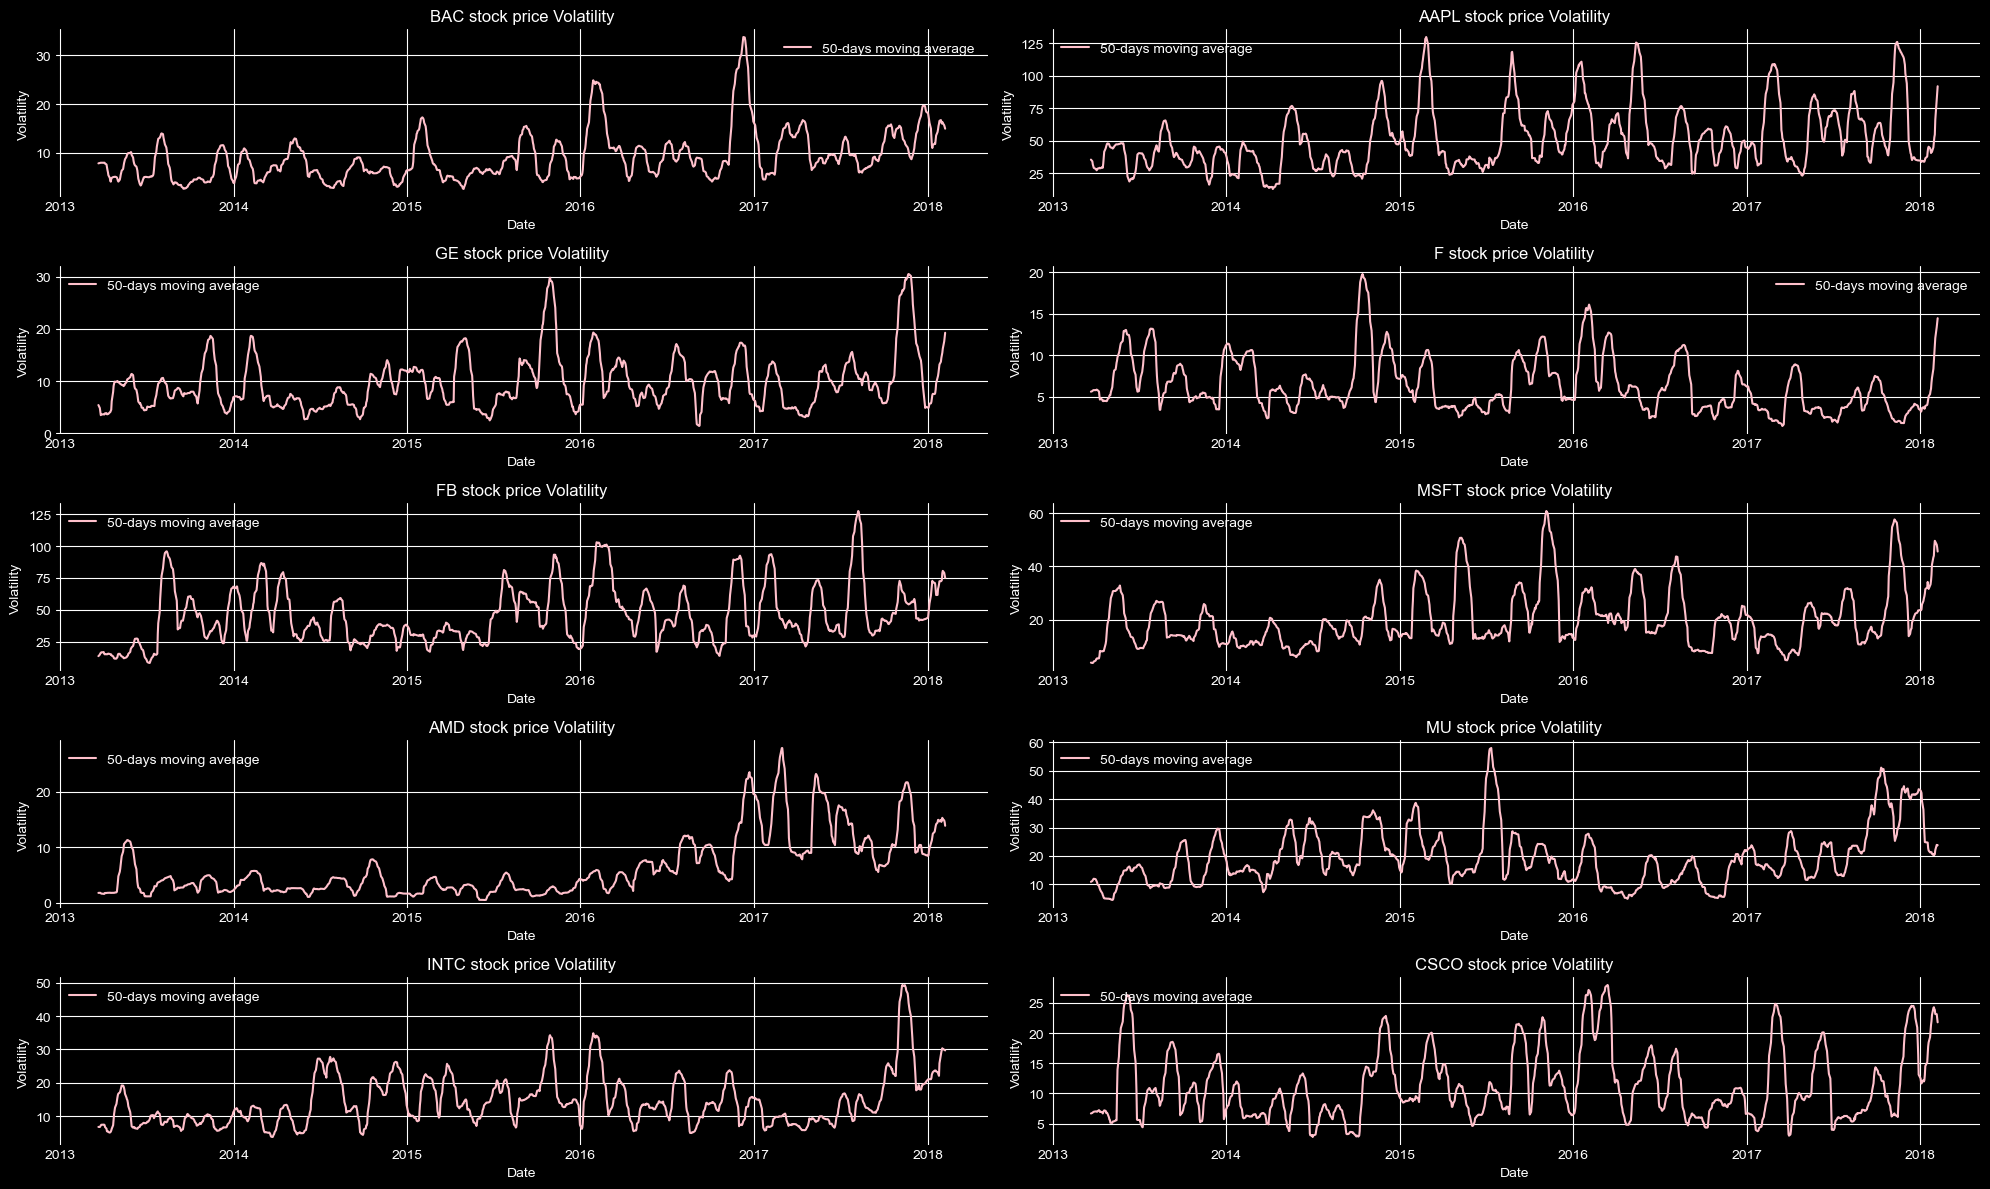

In [328]:
### Plotting sales volume of each company.
plt.style.use('dark_background')
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 12))  # Adjust for 10 plots
axes = axes.flatten()

for i, comp in enumerate(company):
    ax1 = axes[i]
    d = data[data['Name'] == comp]  # Filter data by company
    ma_50 = d['close'].rolling(window=30).std()*np.sqrt(252)
    ax1.plot(d['date'],ma_50, color='pink', label='50-days moving average')
    ax1.set_title(f"{comp} stock price Volatility")
    ax1.set_ylabel('Volatility')
    ax1.set_xlabel('Date')
    ax1.legend()

fig.tight_layout()
plt.show()

### Single stock price predictor

We will select any one of our 10 companies to predict the stock price using LSTM. Prior to making prediction we need to transform the data for the model to be able to use. This will include below steps.

1. Selecting a company
2. Selecting appropriate columns
3. Setting date as the index
4. Splitting data into train and test
5. Scaling the data
6. Creating the trainX, trainY, testX, testY

In [486]:
### Selecting Facebook data along with appropriate column
data_FB = data[data['Name'] == 'FB'][['date', 'open', 'high', 'low', 'close', 'volume',
       'price_change_pct', 'volume_change_pct']]

### removing null values
data_FB.bfill(inplace= True, axis='rows')

### setting date as index
data_FB.set_index('date',inplace=True)
data_FB.head()

,open,high,low,close,volume,price_change_pct,volume_change_pct
date,,,,,,,
2013-02-08,28.89,29.17,28.51,28.5450,37662614,-0.009984,-0.018137
2013-02-11,28.61,28.68,28.04,28.2600,36979533,-0.009984,-0.018137
2013-02-12,27.67,28.16,27.10,27.3700,93417215,-0.031493,1.526187
2013-02-13,27.36,28.32,27.31,27.9075,50100805,0.019638,-0.463688
2013-02-14,28.02,28.63,28.01,28.5000,35581045,0.021231,-0.289811


In [487]:
data_FB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-02-08 to 2018-02-07
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               1259 non-null   float64
 1   high               1259 non-null   float64
 2   low                1259 non-null   float64
 3   close              1259 non-null   float64
 4   volume             1259 non-null   int64  
 5   price_change_pct   1259 non-null   float64
 6   volume_change_pct  1259 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.7 KB


In [630]:
'''
We will be using 80% of the data for training purpose and remaing 20% for testing.
Using slicing we will select the training and testing dataframe.
'''

### calculating training data length
training_data_len =int(np.ceil(len(data_FB) * .8))

### Splitting data
df_for_training = data_FB.iloc[0:int(training_data_len), :]
df_for_testing = data_FB[int(training_data_len):]
print(df_for_training.shape)
print(df_for_testing.shape)

(1008, 7)
(251, 7)


In [631]:
''' 
We will try two different method to scale the data and based on the performace evaluate which to select.
Min Max scaler is simple to use does not deal with outliers
Standard Scaler organise data to follow standard distribution and deals with the outlier.
'''

### standard scaler
scaler_mn = MinMaxScaler(feature_range=(0,1))
train_scaled_data = scaler_mn.fit_transform(df_for_training)

scaler_mn = MinMaxScaler(feature_range=(0,1))
test_scaled_data = scaler_mn.fit_transform(df_for_testing)

# scaler_std = StandardScaler()
# train_scaled_data = scaler_std.fit_transform(df_for_training)

# scaler_std = StandardScaler()
# test_scaled_data = scaler_std.fit_transform(df_for_testing)

In [632]:
train_scaled_data.shape

(1008, 7)

In [633]:
### initialising window size i.e how many previous days of data is required to make todays prediction
window_size = 90

### creating a funtion to split data in to features and outcome for training and test data.
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,3])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(train_scaled_data,window_size)
testX,testY=createXY(test_scaled_data,window_size)


In [634]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(918, 90, 7)
(918,)
(161, 90, 7)
(161,)


In [635]:
# Building the LSTM model
model = Sequential()
model.add(Input(shape=(trainX.shape[1], trainX.shape[2])))  # Explicit Input layer
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=25))
model.add(Dense(units=1))
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 90, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 90, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,426 (154.01 KB)

 Trainable params: 39,426 (154.01 KB)

 Non-trainable params: 0 (0.00 B)

In [636]:
# Compiling and training the LSTM model
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # Adjust as needed
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, batch_size=10, epochs=25)

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0330
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0012
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0012
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0011
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.1545e-04
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0010
Epoch 9/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.0277e-04
Epoch 10/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.8073e-04
Epoch 11/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.0082e-04
Epoch 12/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.5577e-04
Epoch 13/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.8502e-04
Epoch 14/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.4067e-04
Epoch 15/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 2

In [637]:
### Making prediction based on the above trainined model
predictions = model.predict(testX)
predictions.shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


(161, 1)

Since we scaled the data before predicting we need to reverse that transformation so that we can evaluated the model's performance.
However, while scaling there were 7 columns and our prediction has only 1 column. As a result we need to make adjustments before performing inverse transformation.

We will replicate the single column 7 times and then perform inverse transformation on the array.

In [638]:
prediction_copies_array = np.repeat(predictions,7, axis=-1)
pred=scaler_mn.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),7)))[:,0]

Fetching the original data from the testing dataframe so that we have date information to aid visualisation.

In [702]:
original = df_for_testing[window_size:]['close']
original

NameError: name 'window_size' is not defined

In [690]:
### Combining the original and prediction data into a single data frame.
final_data = pd.DataFrame({'Original': original,'Predictions':pred},index = original.index)
final_data

,Original,Predictions
date,,
2017-06-20,152.25,160.463715
2017-06-21,153.91,160.706985
2017-06-22,153.40,161.736694
2017-06-23,155.07,161.663330
2017-06-26,153.59,162.666733
...,...,...
2018-02-01,193.09,191.677307
2018-02-02,190.28,196.770035
2018-02-05,181.26,195.392593


In [691]:
### Evaluating the performance of the LSTM model.
rmse = np.sqrt(mean_squared_error(final_data['Original'], final_data['Predictions']))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 6.921761202185137


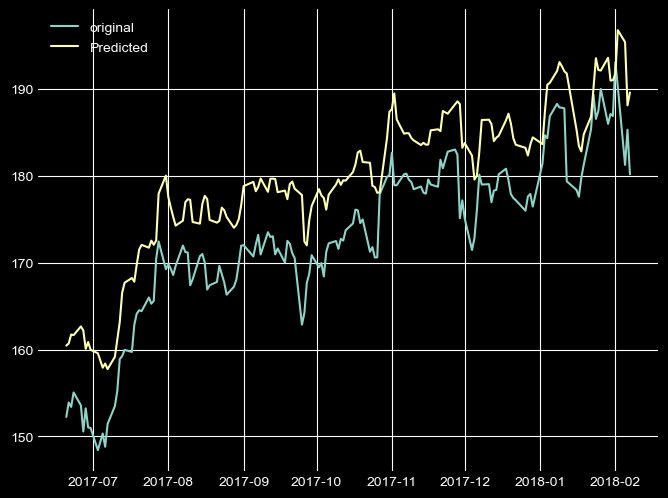

In [701]:
### Plotting the original and prediction data to visualise the performance of the model.
plt.figure(figsize=(8,6))
plt.plot(final_data['Original'],label = 'original')
plt.plot(final_data['Predictions'], label = 'Predicted')
plt.legend()
plt.show()


Based on the above plot we can se that our model was able to predict values that follow the pattern of original values closely. There is definitely difference in the exact value of prediction however the rise and fall is accurately accounted.